# ShopAssist AI

### Project Background



In today's digital age, online shopping has become the go-to option for many consumers.
However, the overwhelming number of choices and the lack of personalized assistance can make the shopping experience daunting.
To address this, we have developed **ShopAssist AI, a chatbot that combines the power of large language models and rule-based 
functions to ensure accurate and reliable information delivery**

### Problem Statement

We are using a dataset from Kaggle ("https://www.kaggle.com/work/collections/14270569?privacy=public") containing mobile phone information 
(mobile names, prices, ratings, etc.) to build a chatbot that parses the
dataset and provides accurate mobile phone recommendations based on user 
requirements. This chatbot, named ShopAssist AI, will:

- Interact with users,
- Understand their mobile phone requirements, and
- Recommend the most suitable phones from the dataset based on their needs and preferences.


# Step 1: Import Libraries and Load The Data

##### Import the required Libraries:

In [1]:
# Import the libraries
import pandas as pd
from IPython.display import display, HTML
import os, json, ast
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt
import re

##### Load The Data

In [2]:

# Set the display width to control the output width
pd.set_option('display.width', 100)
# Read the dataset and read the Laptop Dataset
mobile_data = pd.read_csv('mobile_data.csv')
mobile_data.head(5)

,Unnamed: 0,Mobile Name,Price,Rating,RAM,Display,Camera,Battery,Processor
0,0,"realme C25_Y (Metal Grey, 64 GB)","₹10,999",4.4,4 GB RAM | 64 GB ROM,16.51 cm (6.5 inch) HD+ Display,50MP + 2MP + 2MP | 8MP Front Camera,5000 mAh LiPo Battery,Unisoc T618 Processor
1,1,"realme C25_Y (Metal Grey, 128 GB)","₹11,999",4.4,4 GB RAM | 128 GB ROM,16.51 cm (6.5 inch) HD+ Display,50MP + 2MP + 2MP | 8MP Front Camera,5000 mAh LiPo Battery,Unisoc T618 Processor
2,2,"realme C31 (Dark Green, 32 GB)","₹9,299",4.6,3 GB RAM | 32 GB ROM | Expandable Upto 1 TB,16.56 cm (6.52 inch) HD Display,13MP + 2MP + 0.3MP | 5MP Front Camera,5000 mAh Battery,Unisoc T612 Processor
3,3,"realme C31 (Light Silver, 32 GB)","₹9,299",4.6,3 GB RAM | 32 GB ROM | Expandable Upto 1 TB,16.56 cm (6.52 inch) HD Display,13MP + 2MP + 0.3MP | 5MP Front Camera,5000 mAh Battery,Unisoc T612 Processor
4,4,"realme C31 (Dark Green, 64 GB)","₹9,999",4.4,4 GB RAM | 64 GB ROM | Expandable Upto 1 TB,16.56 cm (6.52 inch) HD Display,13MP + 2MP + 0.3MP | 5MP Front Camera,5000 mAh Battery,Unisoc T612 Processor


# Step 2: Data Preprocessing and Cleaning

In [3]:
mobile_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4296 entries, 0 to 4295
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   4296 non-null   int64 
 1   Mobile Name  4296 non-null   object
 2   Price        4296 non-null   object
 3   Rating       4296 non-null   object
 4   RAM          4296 non-null   object
 5   Display      4296 non-null   object
 6   Camera       4296 non-null   object
 7   Battery      4296 non-null   object
 8   Processor    4296 non-null   object
dtypes: int64(1), object(8)
memory usage: 302.2+ KB


In [4]:
round(100*(mobile_data.isnull().sum()/len(mobile_data.index)),2).sort_values(ascending=False)

Unnamed: 0     0.0
Mobile Name    0.0
Price          0.0
Rating         0.0
RAM            0.0
Display        0.0
Camera         0.0
Battery        0.0
Processor      0.0
dtype: float64

- Ther are no missing values present in data set.


###### Preparing the data as per our need.

- Remove the rupees symbol from Price column. 
- Divide the RAM column into three columns to better understand the Ram size, Internal Storage and Expandable Storage.
- Convert the Mobile_Name into three different columns Brand, Model and Color of mobile.
- Divide the Camera column into two as Rear Camera and Front camera.
- Extract the battery power from the battery column.
- divide Display column into two as display size in inch and display type.





In [5]:
mobile_data['Price'] = mobile_data['Price'].replace('[₹,]', '', regex=True).astype(int)

def parse_ram_column(ram_value):
    parts = ram_value.split(' | ')
    ram_size = parts[0] if len(parts) > 0 else None
    storage = parts[1] if len(parts) > 1 else None
    expandable_storage = None
    if len(parts) > 2:
        match = re.search(r'Expandable Upto (.+)', parts[2])
        if match:
            expandable_storage = match.group(1)
    return ram_size, storage, expandable_storage

# Apply the function to the RAM column
mobile_data[['RAM Size', 'Storage', 'Expandable Storage']] = mobile_data['RAM'].apply(lambda x: pd.Series(parse_ram_column(x)))

# Drop the original RAM column
mobile_data.drop(columns=['RAM'], inplace=True)



In [6]:
def split_mobile_name(mobile_name):
    try:
        brand_model, color_storage = mobile_name.split('(', 1)
        brand, model = brand_model.strip().split(maxsplit=1)
        color = color_storage.split(',', 1)[0].strip()
        return brand, model, color
    except ValueError:
        return None, None, None

# Apply the function to the DataFrame
mobile_data[['Brand', 'Model', 'Color']] = mobile_data['Mobile Name'].apply(lambda x: pd.Series(split_mobile_name(x)))

# Drop the original Mobile Name column if no longer needed
mobile_data = mobile_data.drop(columns=['Mobile Name'])

In [7]:
def extract_cameras(camera_value):
    parts = camera_value.split(' | ')
    rear_camera = parts[0] if len(parts) > 0 else None
    front_camera = parts[1] if len(parts) > 1 else None
    return rear_camera, front_camera

# Apply the function to the Camera column
mobile_data[['Rear Camera', 'Front Camera']] = mobile_data['Camera'].apply(lambda x: pd.Series(extract_cameras(x)))

# Drop the original Camera column
mobile_data.drop(columns=['Camera'], inplace=True)


In [8]:
def extract_display_size_inch(text):
    # Extract display size in inch
    pattern = r"\((\d+\.?\d*) inch\)"
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    return None

def extract_display_type(text):
    # Extract everything after the closing parenthesis
    pattern = r"\) (.+)"
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    return None

# Apply the functions to the Display column
mobile_data['Display Size (inch)'] = mobile_data['Display'].apply(extract_display_size_inch)
mobile_data['Display Type'] = mobile_data['Display'].apply(extract_display_type)

# Drop the original Display column
mobile_data.drop(columns=['Display'], inplace=True)

# Display the updated DataFrame
mobile_data.head()

,Unnamed: 0,Price,Rating,Battery,Processor,RAM Size,Storage,Expandable Storage,Brand,Model,Color,Rear Camera,Front Camera,Display Size (inch),Display Type
0,0,10999,4.4,5000 mAh LiPo Battery,Unisoc T618 Processor,4 GB RAM,64 GB ROM,None,realme,C25_Y,Metal Grey,50MP + 2MP + 2MP,8MP Front Camera,6.5,HD+ Display
1,1,11999,4.4,5000 mAh LiPo Battery,Unisoc T618 Processor,4 GB RAM,128 GB ROM,None,realme,C25_Y,Metal Grey,50MP + 2MP + 2MP,8MP Front Camera,6.5,HD+ Display
2,2,9299,4.6,5000 mAh Battery,Unisoc T612 Processor,3 GB RAM,32 GB ROM,1 TB,realme,C31,Dark Green,13MP + 2MP + 0.3MP,5MP Front Camera,6.52,HD Display
3,3,9299,4.6,5000 mAh Battery,Unisoc T612 Processor,3 GB RAM,32 GB ROM,1 TB,realme,C31,Light Silver,13MP + 2MP + 0.3MP,5MP Front Camera,6.52,HD Display
4,4,9999,4.4,5000 mAh Battery,Unisoc T612 Processor,4 GB RAM,64 GB ROM,1 TB,realme,C31,Dark Green,13MP + 2MP + 0.3MP,5MP Front Camera,6.52,HD Display


In [9]:
# Regular expression pattern to match numbers followed by optional 'mAh'
pattern = r"(\d+)(?: mAh)?"

# Define a function to extract the desired part of the string
def extract_mah(text):
    match = re.search(pattern, text)
    if match:
        return match.group()  # Return the matched group (number and optional 'mAh')
    else:
        return None

# Apply the function to the Battery column
mobile_data['Battery'] = mobile_data['Battery'].apply(extract_mah)

In [10]:
# Drop the original Display column
mobile_data.drop(columns=['Unnamed: 0'], inplace=True)


In [11]:
mobile_data.head()

,Price,Rating,Battery,Processor,RAM Size,Storage,Expandable Storage,Brand,Model,Color,Rear Camera,Front Camera,Display Size (inch),Display Type
0,10999,4.4,5000 mAh,Unisoc T618 Processor,4 GB RAM,64 GB ROM,None,realme,C25_Y,Metal Grey,50MP + 2MP + 2MP,8MP Front Camera,6.5,HD+ Display
1,11999,4.4,5000 mAh,Unisoc T618 Processor,4 GB RAM,128 GB ROM,None,realme,C25_Y,Metal Grey,50MP + 2MP + 2MP,8MP Front Camera,6.5,HD+ Display
2,9299,4.6,5000 mAh,Unisoc T612 Processor,3 GB RAM,32 GB ROM,1 TB,realme,C31,Dark Green,13MP + 2MP + 0.3MP,5MP Front Camera,6.52,HD Display
3,9299,4.6,5000 mAh,Unisoc T612 Processor,3 GB RAM,32 GB ROM,1 TB,realme,C31,Light Silver,13MP + 2MP + 0.3MP,5MP Front Camera,6.52,HD Display
4,9999,4.4,5000 mAh,Unisoc T612 Processor,4 GB RAM,64 GB ROM,1 TB,realme,C31,Dark Green,13MP + 2MP + 0.3MP,5MP Front Camera,6.52,HD Display


- Now check again the data types of columns and convert into a proper data type. 

In [12]:
mobile_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4296 entries, 0 to 4295
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Price                4296 non-null   int32 
 1   Rating               4296 non-null   object
 2   Battery              3936 non-null   object
 3   Processor            4296 non-null   object
 4   RAM Size             4296 non-null   object
 5   Storage              3792 non-null   object
 6   Expandable Storage   2745 non-null   object
 7   Brand                3875 non-null   object
 8   Model                3875 non-null   object
 9   Color                3875 non-null   object
 10  Rear Camera          4296 non-null   object
 11  Front Camera         3588 non-null   object
 12  Display Size (inch)  4280 non-null   object
 13  Display Type         4293 non-null   object
dtypes: int32(1), object(13)
memory usage: 453.2+ KB


In [13]:
# Convert data types
mobile_data['Price'] = mobile_data['Price'].astype('int32')
mobile_data['Rating'] = pd.to_numeric(mobile_data['Rating'], errors='coerce')
mobile_data['Battery'] = pd.to_numeric(mobile_data['Battery'].str.extract('(\d+)')[0], errors='coerce')
mobile_data['RAM Size'] = pd.to_numeric(mobile_data['RAM Size'].str.extract('(\d+)')[0], errors='coerce')
mobile_data['Storage'] = pd.to_numeric(mobile_data['Storage'].str.extract('(\d+)')[0], errors='coerce')
mobile_data['Expandable Storage'] = pd.to_numeric(mobile_data['Expandable Storage'].str.extract('(\d+)')[0], errors='coerce')
mobile_data['Display Size (inch)'] = pd.to_numeric(mobile_data['Display Size (inch)'], errors='coerce')




In [14]:
print(mobile_data.dtypes)


Price                    int32
Rating                 float64
Battery                float64
Processor               object
RAM Size               float64
Storage                float64
Expandable Storage     float64
Brand                   object
Model                   object
Color                   object
Rear Camera             object
Front Camera            object
Display Size (inch)    float64
Display Type            object
dtype: object


In [15]:
round(100*(mobile_data.isnull().sum()/len(mobile_data.index)),2).sort_values(ascending=False)

Expandable Storage     36.10
Front Camera           16.48
Storage                11.82
Brand                   9.80
Model                   9.80
Color                   9.80
Battery                 8.38
Rating                  2.28
Display Size (inch)     0.37
RAM Size                0.09
Display Type            0.07
Price                   0.00
Processor               0.00
Rear Camera             0.00
dtype: float64

In [16]:
# Replace null values in numeric columns with mean
mobile_data['Rating'].fillna(mobile_data['Rating'].mean(), inplace=True)
mobile_data['RAM Size'].fillna(mobile_data['RAM Size'].mean(), inplace=True)
mobile_data['Storage'].fillna(mobile_data['Storage'].mean(), inplace=True)
mobile_data['Expandable Storage'].fillna(mobile_data['Expandable Storage'].mean(), inplace=True)

mobile_data['Display Size (inch)'].fillna(mobile_data['Display Size (inch)'].mean(), inplace=True)
mobile_data['Battery'].fillna(mobile_data['Battery'].mean(), inplace=True)

In [17]:
mobile_data = mobile_data.dropna(subset=['Brand', 'Model', 'Color'])

In [18]:
mobile_data = mobile_data.dropna(subset=['Front Camera'])

In [19]:
mobile_data = mobile_data.dropna(subset=['Display Type'])

In [20]:
round(100*(mobile_data.isnull().sum()/len(mobile_data.index)),2).sort_values(ascending=False)

Price                  0.0
Rating                 0.0
Battery                0.0
Processor              0.0
RAM Size               0.0
Storage                0.0
Expandable Storage     0.0
Brand                  0.0
Model                  0.0
Color                  0.0
Rear Camera            0.0
Front Camera           0.0
Display Size (inch)    0.0
Display Type           0.0
dtype: float64

In [21]:
mobile_data.head(2)

,Price,Rating,Battery,Processor,RAM Size,Storage,Expandable Storage,Brand,Model,Color,Rear Camera,Front Camera,Display Size (inch),Display Type
0,10999,4.4,5000.0,Unisoc T618 Processor,4.0,64.0,183.128597,realme,C25_Y,Metal Grey,50MP + 2MP + 2MP,8MP Front Camera,6.5,HD+ Display
1,11999,4.4,5000.0,Unisoc T618 Processor,4.0,128.0,183.128597,realme,C25_Y,Metal Grey,50MP + 2MP + 2MP,8MP Front Camera,6.5,HD+ Display


# Step 3: System Design

###### Approch:

1. **Conversation and Information Gathering**: The chatbot will utilize language models to understand and generate natural responses. Through a conversational flow, it will ask relevant questions to gather information about the user's requirements.
2. **Information Extraction**: Once the essential information is collected, rule-based functions come into play, extracting top 3 laptops that best matches the user's needs.
3. **Personalized Recommendation**: Leveraging this extracted information, the chatbot engages in further dialogue with the user, efficiently addressing their queries and aiding them in finding the perfect laptop solution.

### Dataset

We have a dataset `mobile_data.csv` where  each row describes the features of a single mobile phone
and we also add a one Feature column in the data set at the end. The chatbot that we build will leverage 
LLMs to parse this `Feature` column and provide recommendations.

#### Workings of the Chatbot

**Note1** - Don't run this when you go through this section for the first time. Run this only after running through the rest of the code. When going through this for the first time, please only go through the output, to understand the workings of the chatbot

**Note2** - The conversation shown here might be different from what you see in the video. However, the overall structure of the conversation to understand the system design remains the same.

In [22]:
# RUN THIS ONCE ALL THE FUNCTION LAYERS HAVE BEEN DEFINED
#dialogue_mgmt_system()

#### Building the Chatbot



- Now let's go ahead and understand the system design for the chatbot.
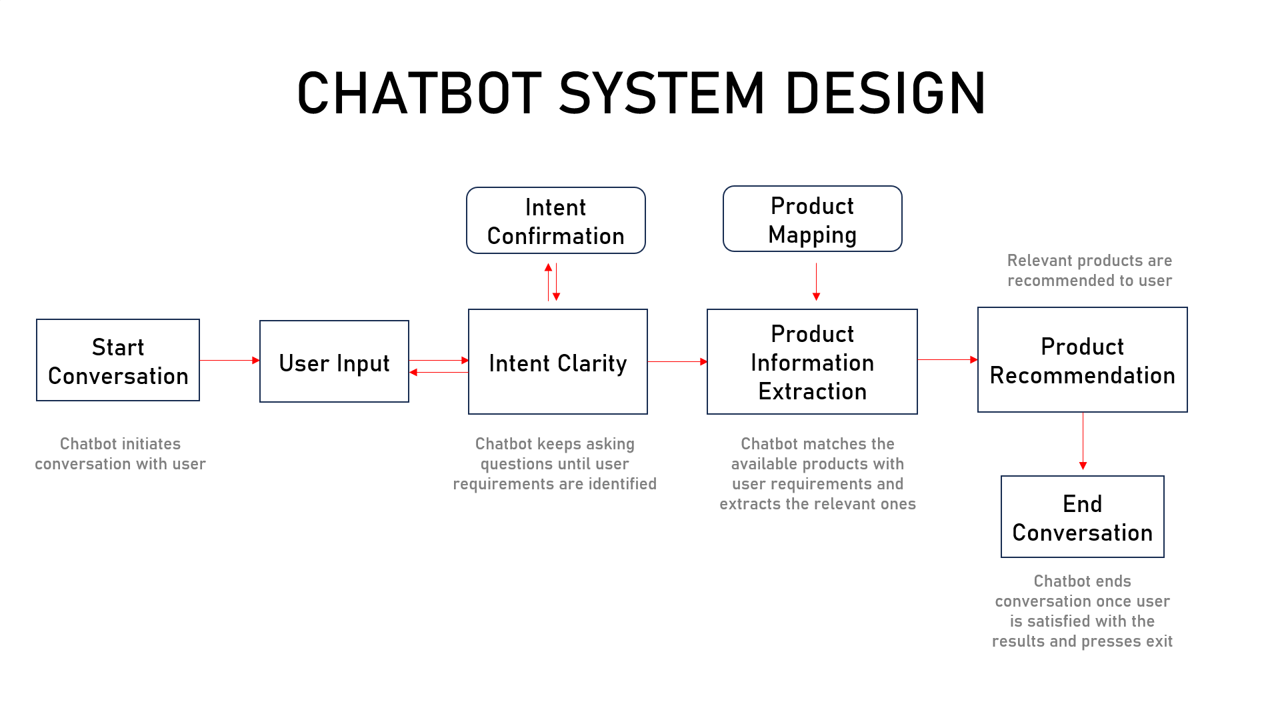



`Stage 1`

- Intent Clarity Layer
- Intent Confirmation Layer

`Stage 2`

- Product Mapping Layer
- Product Information Extraction Layer

`Stage 3`

- Product Recommendation Layer

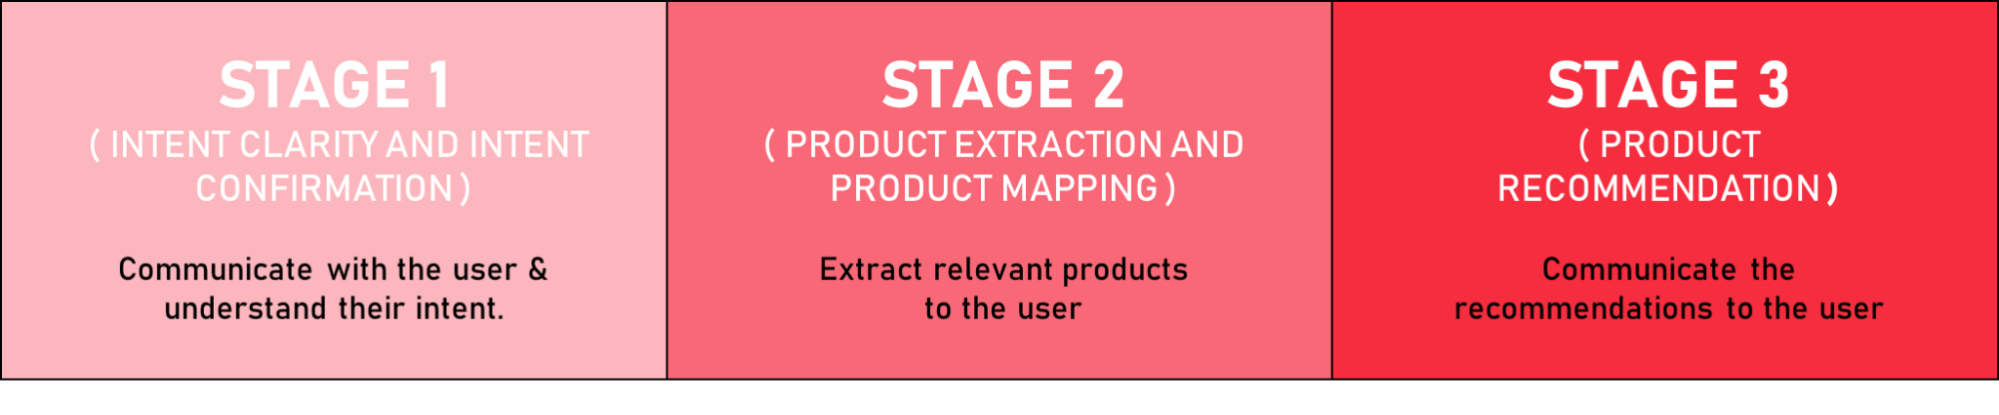

#### Major functions behind the Chatbot



Let's now look at a brief overview of the major functions that form the chatbot. We'll take a deep dive later



- `initialize_conversation()`: This initializes the variable conversation with the system message.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant
- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not Ram, Storage, Rating, Display size, Rear Camera,Front Camera, Battery Life and Budget.
- `dictionary_present()`: This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- `compare_mobiles_with_user()`: This function compares the user's profile with the different mobiles and come back with the top 3 recommendations.
- `initialize_conv_reco()`: Initializes the recommendations conversation

In the next sections, we will look at how to write the code for the above functions.

## Step 4: Implementation

## Stage 1

- Stage 1 Flowchart

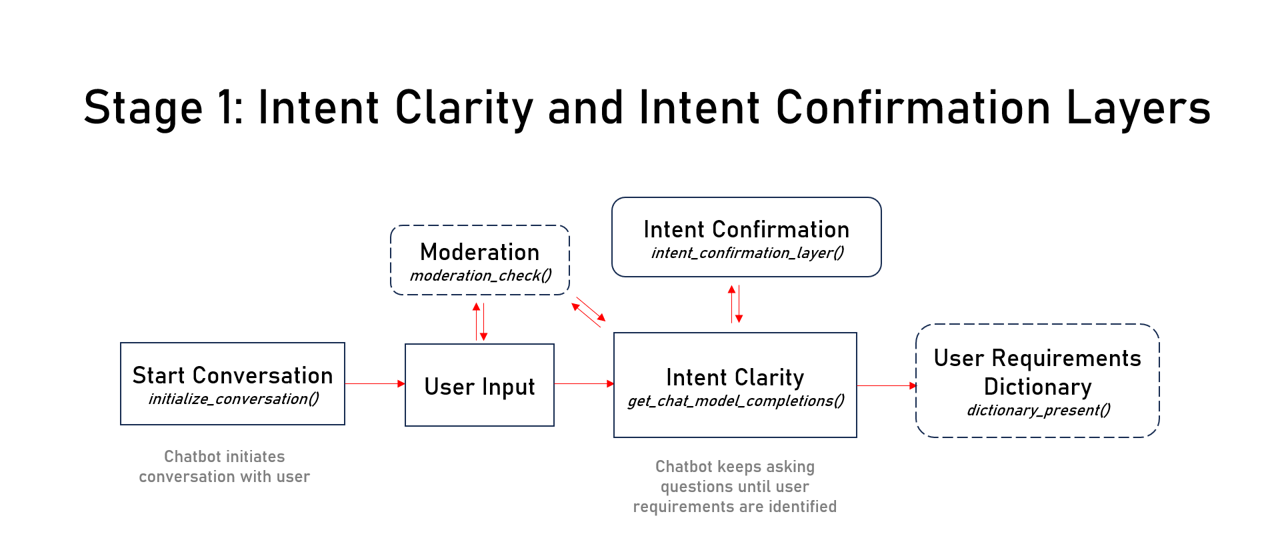

Let's start the project with api key.

Note: Before proceeding, ensure you have your OpenAI API key. This key is necessary for the chatbot to make calls to the OpenAI API. Insert your API key in the designated area in the code.

In [23]:
%%writefile "config.py"
api_key = "sk-pro"

Overwriting config.py


In [24]:
openai.api_key ="sk-pro"

In [25]:
from config import api_key
# assign api_key
openai.api_key = api_key
os.environ["OPENAI_API_KEY"] = api_key

### 3.2 - Implementing Intent Clarity and Intent Confirmation Layers

Let's start with the first part of the implementation - building the `intent clarity` and `intent confirmation` layers. As mentioned earlier, this layer helps in identifying the user requirements and passing it on to the product matching layer. Here are the functions that we would be using for building these layers:

- `initialize_conversation()`

### `initialize_conversation()`:
This initializes the variable conversation with the system message. Using prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting(sample conversation between the user and assistant) to align the model about user and assistant responses at each step.

```
def initialize_conversation():
    '''
    Initializes a conversation for an intelligent mobile phone expert system.

    Returns:
        list: [{"role": "system", "content": system_message}]
        A list containing a dictionary representing the system's initial message.
        
    The function initiates a conversation with the user, providing guidance on how to interact effectively. The initial message outlines the purpose, instructions for completing a user profile, and examples to demonstrate the interaction.

The system expects the user to provide details related to their mobile phone preferences, such as budget, rating, RAM size, storage, rear camera, front camera, display size (inch), and battery. This information is used to update a dictionary representing the user's preferences, ensuring accurate recommendations.

The conversation flow consists of three main steps:

Understanding User Preferences: Gathering and filling confident values based on user input.
Completing the Profile: Using gathered information to fill in remaining preferences.
Confirmation: Verifying the updated dictionary to ensure it accurately reflects the user's needs.
Users are encouraged to engage meaningfully to ensure their profile is well-represented, allowing for tailored recommendations for the best mobile phone choices.

    Usage:
        # Initialise the conversation
        conversation = initialize_conversation()
        # Print the conversation
        print(conversation)
    '''
    ```

In [26]:
def initialize_conversation():
    '''
    Returns a list [{"role": "system", "content": system_message}]
    '''

    delimiter = "####"

    customer_requirements_dict = {
        'Budget': 12000,  # Example budget in your local currency
        'Rating': 'high',   # Example preferred rating ('high', 'medium', 'low')
        'RAM Size': 4,   # Example minimum RAM size requirement in GB
        'Storage': 64,   # Example minimum internal storage requirement in GB
        'Rear Camera': 'high',  # Example preferred rear camera quality ('high', 'medium', 'low')
        'Front Camera': 'high',  # Example preferred front camera quality ('high', 'medium', 'low')
        'Display Size (inch)': 6.5,  # Example preferred minimum screen size in inches
        'Battery Life': 'long' # Example preferred battery life ('long', 'medium', 'short')
    }

    customer_requirements = {
        'Budget': "-",  # Example budget in your local currency
        'Rating': "-",   # Example preferred rating ('high', 'medium', 'low')
        'RAM Size': "-",   # Example minimum RAM size requirement in GB
        'Storage': "-",   # Example minimum internal storage requirement in GB
        'Rear Camera': "-",  # Example preferred rear camera quality ('high', 'medium', 'low')
        'Front Camera': "-",  # Example preferred front camera quality ('high', 'medium', 'low')
        'Display Size (inch)':"-",  # Example preferred minimum screen size in inches
        'Battery Life': "-" # Example preferred battery life ('long', 'medium', 'short')
    }

    system_message = f"""
    You are an intelligent mobile gadget expert and your goal is to find the best mobile phone for a user.
    You need to ask relevant questions and understand the user's profile by analyzing the user's responses. 
    Your final objective is to fill the values for the different keys in the Python dictionary and be confident of the values.
    These key-value pairs define the user's profile.
    {delimiter}
    The Python dictionary looks like this:
    {{
        'Budget': {customer_requirements['Budget']},
        'Rating': {customer_requirements['Rating']},
        'RAM Size': {customer_requirements['RAM Size']},
        'Storage': {customer_requirements['Storage']},
        'Rear Camera': {customer_requirements['Rear Camera']},
        'Front Camera': {customer_requirements['Front Camera']},
        'Display Size (inch)': {customer_requirements['Display Size (inch)']},
        'Battery Life': {customer_requirements['Battery Life']}
    }}
    {delimiter}
    The values for 'Battery Life' should be 'long' , 'short', 'medium' based on the importance of user's mobile usage.
    The values for 'Rear Camera' and 'Front Camera' should be 'low', 'medium', or 'high' based on the importance of camera 
    quality to the user. All the values in the example dictionary are only representative values.
    {delimiter}
    Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalized:
    - The values for 'Budget', 'RAM Size', 'Storage', and 'Display Size (inch)' should be numerical values extracted from the
    user's response.
    - 'Budget' should be greater than or equal to 1000. If the user mentions less than that, please inform them that there are
    no mobile phones in that range.
    - Do not randomly assign values to any of the keys.
    - The values need to be inferred from the user's response.
    {delimiter}

    To fill the dictionary, you need to have the following chain of thoughts:
    Follow the chain-of-thoughts below and only output the final updated Python dictionary for the keys as described in the example_user_req.
    {delimiter}
    Thought 1: Ask a question to understand the user's requirements. If their primary requirements for the mobile phone are
    unclear, ask follow-up questions to understand their needs. You are trying to fill the values of all the keys
    {{'Rear Camera', 'Front Camera', 'Rating', 'RAM Size', 'Storage', 'Display Size (inch)', 'Battery Life','Budget'}} in the Python dictionary by understanding the user requirements. Identify the keys for which you can fill the values confidently using the understanding. Remember the instructions around the values for the different keys. If the necessary information has been extracted, only then proceed to the next step. Otherwise, rephrase the question to capture their profile clearly.
    {delimiter}
    Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step. 
    Remember the instructions around the values for the different keys. Ask questions you might have for all the keys to
    strengthen your understanding of the user's profile. If yes, move to the next Thought. If no, ask questions on the keys
    whose values you are unsure of. It is a good practice to ask questions with sound logic as opposed to directly citing the 
    key you want to understand the value for.
    {delimiter}
    Thought 3: Check if you have correctly updated the values for the different keys in the Python dictionary. 
    If you are not confident about any of the values, ask clarifying questions.
    {delimiter}

    Here is a sample conversation between the user and assistant:
    User: "Hi, I need a new mobile phone."
    Assistant: "Hello! I'd be happy to help you find the perfect mobile phone. To start, could you tell me a bit about how you use your phone? For example, do you use it more for photography, gaming, or everyday tasks?"
    User: "I mostly use it for photography and social media."
    Assistant: "Great! Since you prioritize photography, we'll focus on phones with good camera quality. Could you let me know your preferences for rear and front camera quality? Do you have a preference for a specific brand or any other features?"
    User: "I prefer high quality for both rear and front cameras, and I like to use Samsung phones."
    Assistant: "Got it. High camera quality and a preference for Samsung. What about the other features like RAM size, storage capacity, and battery life? Do you have any specific requirements or preferences for those?"
    User: "I need at least 4GB of RAM and 64GB of storage. For battery, I prefer a high battery life."
    Assistant: "Thanks for the details. One last thing: what's your budget for the new phone?"
    User: "My budget is around 20000."
    Assistant: "{customer_requirements}"
    {delimiter}

    Start with a short welcome message and encourage the user to share their requirements.
    """

    conversation = [{"role": "system", "content": system_message}]
    return conversation

In [27]:
debug_conversation = initialize_conversation()
print(debug_conversation)

[{'role': 'system', 'content': '\n    You are an intelligent mobile gadget expert and your goal is to find the best mobile phone for a user.\n    You need to ask relevant questions and understand the user\'s profile by analyzing the user\'s responses. \n    Your final objective is to fill the values for the different keys in the Python dictionary and be confident of the values.\n    These key-value pairs define the user\'s profile.\n    ####\n    The Python dictionary looks like this:\n    {\n        \'Budget\': -,\n        \'Rating\': -,\n        \'RAM Size\': -,\n        \'Storage\': -,\n        \'Rear Camera\': -,\n        \'Front Camera\': -,\n        \'Display Size (inch)\': -,\n        \'Battery Life\': -\n    }\n    ####\n    The values for \'Battery Life\' should be \'long\' , \'short\', \'medium\' based on the importance of user\'s mobile usage.\n    The values for \'Rear Camera\' and \'Front Camera\' should be \'low\', \'medium\', or \'high\' based on the importance of camera

In [28]:
# Let's look at the content in the debug_conversation key
print(debug_conversation[0]['content'])


    You are an intelligent mobile gadget expert and your goal is to find the best mobile phone for a user.
    You need to ask relevant questions and understand the user's profile by analyzing the user's responses. 
    Your final objective is to fill the values for the different keys in the Python dictionary and be confident of the values.
    These key-value pairs define the user's profile.
    ####
    The Python dictionary looks like this:
    {
        'Budget': -,
        'Rating': -,
        'RAM Size': -,
        'Storage': -,
        'Rear Camera': -,
        'Front Camera': -,
        'Display Size (inch)': -,
        'Battery Life': -
    }
    ####
    The values for 'Battery Life' should be 'long' , 'short', 'medium' based on the importance of user's mobile usage.
    The values for 'Rear Camera' and 'Front Camera' should be 'low', 'medium', or 'high' based on the importance of camera 
    quality to the user. All the values in the example dictionary are only representati

In [29]:
# Let's initialise conversation
system_message = initialize_conversation()
print(system_message[0]["content"])


    You are an intelligent mobile gadget expert and your goal is to find the best mobile phone for a user.
    You need to ask relevant questions and understand the user's profile by analyzing the user's responses. 
    Your final objective is to fill the values for the different keys in the Python dictionary and be confident of the values.
    These key-value pairs define the user's profile.
    ####
    The Python dictionary looks like this:
    {
        'Budget': -,
        'Rating': -,
        'RAM Size': -,
        'Storage': -,
        'Rear Camera': -,
        'Front Camera': -,
        'Display Size (inch)': -,
        'Battery Life': -
    }
    ####
    The values for 'Battery Life' should be 'long' , 'short', 'medium' based on the importance of user's mobile usage.
    The values for 'Rear Camera' and 'Front Camera' should be 'low', 'medium', or 'high' based on the importance of camera 
    quality to the user. All the values in the example dictionary are only representati

Let's now look at the next function.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant. We'll use the Chat Completions function for performing LLM calls to OpenAI.

### `get_chat_completions()`:

This function perform LLM call using the Chat Completions API to get the LLM response.

In [30]:
# Define a Chat Completions API call
# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_chat_completions(input, json_format = False):
    MODEL = 'gpt-3.5-turbo'

    system_message_json_output = """<<. Return output in JSON format to the key output.>>"""

    # If the output is required to be in JSON format
    if json_format == True:
        # Append the input prompt to include JSON response as specified by OpenAI
        input[0]['content'] += system_message_json_output

        # JSON return type specified
        chat_completion_json = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            response_format = { "type": "json_object"},
            seed = 1234)

        output = json.loads(chat_completion_json.choices[0].message.content)

    # No JSON return type specified
    else:
        chat_completion = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            seed = 2345)

        output = chat_completion.choices[0].message.content

    return output

In [31]:
# Testing the OpenAI functions defined above
input_prompt ='What is the capital of France?'
messages = [{'role':'user','content':input_prompt}]
# system_message_json_output = """<<. Return output in JSON format.>>"""
# messages[0]['content']+=system_message_json_output
messages

[{'role': 'user', 'content': 'What is the capital of France?'}]

In [32]:
## Get LLM Outputs - normal
get_chat_completions(messages) ## Chat Completions API

'The capital of France is Paris.'

In [33]:
## Get LLM Outputs - JSON output
get_chat_completions(messages, json_format = True) ## Chat Completions API and return in JSON format

{'output': 'Paris'}

### iterate_response() - Helper Function:
We've created a small helper test function to ensure the model's response is consistent.
Uncomment the code blocks and run the function `iterate_response(response)` to check if the response of the `intent_confirmation_layer`is consistent.}

In [34]:
def iterate_llm_response(funct, debug_response, num = 10):
    """
    Calls a specified function repeatedly and prints the results.
    This function is designed to test the consistency of a response from a given function.
    It calls the function multiple times (default is 10) and prints out the iteration count,
    the function's response(s).
    Args:
        funct (function): The function to be tested. This function should accept a single argument
                          and return the response value(s).
        debug_response (dict): The input argument to be passed to 'funct' on each call.
        num (int, optional): The number of times 'funct' will be called. Defaults to 10.
    Returns:
        This function only returns the results to the console.
    """
    i = 0  # Initialize counter

    while i < num:  # Loop to call the function 'num' times

        response = funct(debug_response)  # Call the function with the debug response

        # Print the iteration number, result, and reason from the response
        print("Iteration: {0}".format(i))
        print(response)
        print('-' * 50)  # Print a separator line for readability
        i += 1  # Increment the counter

# Example usage: test the consistency of responses from 'intent_confirmation_layer'
# iterate_llm_response(get_chat_completions, messages)

Let's pass the initialized conversation `debug_conversation` and see what is the assistant's response.

In [35]:
debug_user_input = "Hi, I am Anand. I need a new mobile phone."

In [36]:
debug_conversation.append({"role": "user", "content": debug_user_input})
# print(debug_conversation[0]["content"]) # System Message
print(debug_conversation[1]["content"]) # User Input

Hi, I am Anand. I need a new mobile phone.


In [37]:
# Let's look at the debug_conversation list
display(debug_conversation)

[{'role': 'system',
  'content': '\n    You are an intelligent mobile gadget expert and your goal is to find the best mobile phone for a user.\n    You need to ask relevant questions and understand the user\'s profile by analyzing the user\'s responses. \n    Your final objective is to fill the values for the different keys in the Python dictionary and be confident of the values.\n    These key-value pairs define the user\'s profile.\n    ####\n    The Python dictionary looks like this:\n    {\n        \'Budget\': -,\n        \'Rating\': -,\n        \'RAM Size\': -,\n        \'Storage\': -,\n        \'Rear Camera\': -,\n        \'Front Camera\': -,\n        \'Display Size (inch)\': -,\n        \'Battery Life\': -\n    }\n    ####\n    The values for \'Battery Life\' should be \'long\' , \'short\', \'medium\' based on the importance of user\'s mobile usage.\n    The values for \'Rear Camera\' and \'Front Camera\' should be \'low\', \'medium\', or \'high\' based on the importance of came

In [38]:
# Getting the response from the Assistant by passing the conversation to the Chat Completions API
debug_response_assistant = get_chat_completions(debug_conversation)
display(debug_response_assistant)

"Hello Anand! I'd be happy to help you find the perfect mobile phone. To start, could you tell me a bit about how you use your phone? For example, do you use it more for photography, gaming, or everyday tasks? This will help me understand your requirements better."

Let's play around a bit and add the following user's input `debug_user_input` to the conversation `debug_conversation` and see what the assistant responds with.

In [39]:
# Let's append this to the conversation list
debug_conversation.append(({"role": "system", "content": debug_response_assistant}))
debug_conversation

[{'role': 'system',
  'content': '\n    You are an intelligent mobile gadget expert and your goal is to find the best mobile phone for a user.\n    You need to ask relevant questions and understand the user\'s profile by analyzing the user\'s responses. \n    Your final objective is to fill the values for the different keys in the Python dictionary and be confident of the values.\n    These key-value pairs define the user\'s profile.\n    ####\n    The Python dictionary looks like this:\n    {\n        \'Budget\': -,\n        \'Rating\': -,\n        \'RAM Size\': -,\n        \'Storage\': -,\n        \'Rear Camera\': -,\n        \'Front Camera\': -,\n        \'Display Size (inch)\': -,\n        \'Battery Life\': -\n    }\n    ####\n    The values for \'Battery Life\' should be \'long\' , \'short\', \'medium\' based on the importance of user\'s mobile usage.\n    The values for \'Rear Camera\' and \'Front Camera\' should be \'low\', \'medium\', or \'high\' based on the importance of came

Typically, whenever the chatbot is interacting with the user, all the conversations should be moderated to identify any inappropriate content. Let's look at the function that can help with it.

### `moderation_check()`:
 This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, you can add a break statement to end the conversation.

In [40]:
# Define a function called moderation_check that takes user_input as a parameter.

def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = openai.moderations.create(input=user_input)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

In [41]:
moderation_check("I want to kill them.")

'Flagged'

In [42]:
moderation_check("Hi how are you? I am good ")

'Not Flagged'

Let's test moderation on the `debug_user_input`

In [43]:
debug_moderation = moderation_check(debug_user_input)
print(debug_moderation)

Not Flagged


Let's now test moderation on some other text.

In [44]:
print(moderation_check("I want to kill Ravan."))
print(moderation_check("I need a mobile"))

Flagged
Not Flagged


So, this moderation api may not be perfect but if you ask this to the ChatGPT or it's API (GPT 3.5), it'll not help you with such requests. Remember, moderation should also be applied on the GPT 3.5's output.

Let's now check moderation on the assistant's response `debug_response_assistant`.

In [45]:
moderation_check(debug_response_assistant)

'Not Flagged'

As mentioned earlier, you need to understand the user's profile, which essentially means that all the features: 'Rear Camera', 'Front Camera', 'Rating', 'RAM Size', 'Storage', 'Display Size (inch)', 'Battery Life', and 'Budget' are captured or not. Let's look at the function that helps us verify that.

### `intent_confirmation_layer()`:

This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not
- 'Budget'
- 'Rating'
- 'RAM Size'
- 'Storage'
- 'Rear Camera'
- 'Front Camera'
- 'Display Size (inch)'
- 'Battery Life'

```
def intent_confirmation_layer(response_assistant):
    """
    This function serves as an intent confirmation layer for a smartphone recommendation system.

    Parameters:
    - response_assistant (str): The input text containing user requirements captured through 8 keys:
        'Rear Camera', 'Front Camera', 'Rating', 'RAM Size', 'Storage', 'Display Size (inch)', 'Battery Life', and 'Budget'.

    Returns:
    - str: A one-word string in JSON format indicating if the values for the specified keys are correctly filled.
        - 'Yes' if the values are correctly filled for all keys ('Rear Camera', 'Front Camera', 'Rating', 'RAM Size',
          'Storage', 'Display Size (inch)', 'Battery Life', and 'Budget') based on the importance as stated by the user.
        - 'No' otherwise.

    Note:
    - The values for 'Rear Camera', 'Front Camera', and 'Rating' should be 'high', 'medium', or 'low'.
    - The value for 'Battery Life' should be 'long', 'medium', or 'short'.
    - The other key values ('RAM Size', 'Storage', 'Display Size (inch)', 'Budget') should be in numeric form.
    - The input text should be structured such that it contains the necessary keys and their corresponding values.
    """
```

In [46]:
def intent_confirmation_layer(response_assistant):
    
    delimeter="####"
    
    allowed_values = {'low', 'medium', 'high'}
    battery_values = {'long', 'medium', 'short'}

    
    prompt = f"""
    You are a senior evaluator with an eye for detail. The input text will contain user requirements captured through 8 keys.
    You are provided an input. You need to evaluate if the input text has the following keys:
    {{
    'Budget': 'number',
    'Rating': 'values',
    'RAM Size': 'number',
    'Storage': 'number',
    'Rear Camera': 'values',
    'Front Camera': 'values',
    'Display Size (inch)': 'number',
    'Battery Life': 'values',
    }}
    The values for 'Rear Camera', 'Front Camera', and 'Rating' should only be from the allowed values: {allowed_values}.
    The value for 'Battery Life' should only be from the allowed values: {battery_values}.
    The other keys ('RAM Size', 'Storage', 'Display Size (inch)', 'Budget') should have numeric values.
    Next, you need to evaluate if the keys have the values filled correctly.
    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Thought 1 - Output 'Yes' if the values are correctly filled for all keys, even if a single key missing output should be 'No'.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'.
    Thought 3 - Think carefully before answering.
    """

    messages=[{"role": "system", "content":prompt },
              {"role": "user", "content":f"""Here is the input: {response_assistant}""" }]

    response = openai.chat.completions.create(
                                    model="gpt-3.5-turbo",
                                    messages = messages,
                                    response_format={ "type": "json_object" },
                                    seed = 1234
                                    # n = 5
                                    )

    json_output = json.loads(response.choices[0].message.content)

    return json_output


Let's apply the function to the assistant's reponse and see if it has captured the user profile.

In [47]:
debug_response_assistant

"Hello Anand! I'd be happy to help you find the perfect mobile phone. To start, could you tell me a bit about how you use your phone? For example, do you use it more for photography, gaming, or everyday tasks? This will help me understand your requirements better."

In [48]:
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
display(debug_confirmation)

{'result': 'No', 'reason': 'Missing required keys'}

In [49]:
# Printing the value for better clarity
print("Result:",debug_confirmation.get('result'),"\t", "Reason:", debug_confirmation.get('reason'))

Result: No 	 Reason: Missing required keys


Now, you can keep adding user and assistant responses to debug_conversation and get to a point where intent_confirmation_layer() gives yes as a response. Let's see if the following response by the assistant passes the intent_confirmation_layer() test.

In [50]:
#Let's add the above assistant response to the debug_conversation.
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})

In [51]:
debug_conversation

[{'role': 'system',
  'content': '\n    You are an intelligent mobile gadget expert and your goal is to find the best mobile phone for a user.\n    You need to ask relevant questions and understand the user\'s profile by analyzing the user\'s responses. \n    Your final objective is to fill the values for the different keys in the Python dictionary and be confident of the values.\n    These key-value pairs define the user\'s profile.\n    ####\n    The Python dictionary looks like this:\n    {\n        \'Budget\': -,\n        \'Rating\': -,\n        \'RAM Size\': -,\n        \'Storage\': -,\n        \'Rear Camera\': -,\n        \'Front Camera\': -,\n        \'Display Size (inch)\': -,\n        \'Battery Life\': -\n    }\n    ####\n    The values for \'Battery Life\' should be \'long\' , \'short\', \'medium\' based on the importance of user\'s mobile usage.\n    The values for \'Rear Camera\' and \'Front Camera\' should be \'low\', \'medium\', or \'high\' based on the importance of came

Let's say that after a series of conversations you get the following response from the assistant.

In [52]:
# Example 1 - Let's check with the confirmation_layer if all the keys are present
debug_response_assistant_1 = """
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the mobile phone you are looking for:
{{
        'Budget':'12000',
        'Rating': 'high',
        'RAM Size': 4,
        'Storage': 64,
        'Rear Camera': 'high',
        'Front Camera': 'medium',
        'Display Size (inch)': 6.5,
        'Battery Life': 'long'
}}
"""
#Note that you are using double curly braces

print(debug_response_assistant_1)


Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the mobile phone you are looking for:
{{
        'Budget':'12000',
        'Rating': 'high',
        'RAM Size': 4,
        'Storage': 64,
        'Rear Camera': 'high',
        'Front Camera': 'medium',
        'Display Size (inch)': 6.5,
        'Battery Life': 'long'
}}



Do you think it'll pass the `intent_confirmation_layer()` test?

 Let's try it out.

In [53]:
response = intent_confirmation_layer(debug_response_assistant_1)
print(response)
response.get('result') # Extract the result key from the dictionary

{'result': 'Yes'}


'Yes'

In [54]:
# Example 2 - Let's check confirmation_layer if all the keys are present
debug_response_assistant_2 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the mobile phone you are looking for:
{{
        
        'Rating': 'medium',
        'RAM Size': 4,
        'Storage': 64,
        'Rear Camera': 'high',
        'Front Camera': 'high',
        'Display Size (inch)': 6.5,
        'Battery Life': 'long'
}}
"""
#Note that you are using double curly braces

print(debug_response_assistant_2)


Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the mobile phone you are looking for:
{
        
        'Rating': 'medium',
        'RAM Size': 4,
        'Storage': 64,
        'Rear Camera': 'high',
        'Front Camera': 'high',
        'Display Size (inch)': 6.5,
        'Battery Life': 'long'
}



In [55]:
intent_confirmation_layer(debug_response_assistant_2)
# iterate_llm_response(intent_confirmation_layer, debug_response_assistant_2)

{'result': 'No', 'reason': "Missing keys: 'Budget'."}

In [56]:
# Example 3 - Let's check confirmation_layer if all the keys are present
debug_response_assistant_3 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the mobile phone you are looking for:
{{
        'Budget':'11000',
        'Rating': 'high',
        'RAM Size': 3,
        'Storage': 32,
        'Rear Camera': 'medium',
        'Front Camera': 'low',
        'Display Size (inch)': 4.5,
        'Battery Life': 'medium'
}}
"""
#Note that you are using double curly braces

print(debug_response_assistant_3)


Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the mobile phone you are looking for:
{
        'Budget':'11000',
        'Rating': 'high',
        'RAM Size': 3,
        'Storage': 32,
        'Rear Camera': 'medium',
        'Front Camera': 'low',
        'Display Size (inch)': 4.5,
        'Battery Life': 'medium'
}



In [57]:
intent_confirmation_layer(debug_response_assistant_3)
# iterate_llm_response(intent_confirmation_layer, debug_response_assistant_3)

{'result': 'Yes'}

Let's now look at the working of `dictionary_present()`.

### `dictionary_present()`:

This function checks if the final understanding of user's profile is returned by the chatbot is a Python dictionary or not. This is important as it'll be used later on for finding the right mobiles using dictionary matching.

In [58]:
def dictionary_present(response):
    delimiter = "####"

    user_req = {
        'Budget': '40000',
        'Rating': 'high',
        'RAM Size': '6',
        'Storage': '64',
        'Rear Camera': 'high',
        'Front Camera': 'medium',
        'Display Size (inch)': '6',
        'Battery Life': 'medium'
    }

    prompt = f"""You are a python expert. You are provided an input.
    You have to check if there is a python dictionary present in the string.
    It will have the following format {user_req}.
    Your task is to just extract the relevant values from the input and return only the python dictionary in JSON format.
    The output should match the format as {user_req}.

    {delimiter}
    Make sure that the value of Budget is also present in the user input. ###
    The output should contain the exact keys and values as present in the input.
    Ensure the keys and values are in the given format:
    {{   
        'Budget': 'number',
        'Rating': 'values',
        'RAM Size': 'number',
        'Storage': 'number',
        'Rear Camera': 'values',
        'Front Camera': 'values',
        'Display Size (inch)': 'number',
        'Battery Life': 'values'
    }}
    Here are some sample input output pairs for better understanding:
    {delimiter}
    input 1: - {{'Budget': 'number','Rating': 'values', 'RAM Size': 'number', 'Storage': 'number','Rear Camera': 'values','Front Camera': 'values','Display Size (inch)': 'number','Battery Life': 'values'}} 
    output 1: {{'Budget': 12000, 'Rating': 'low' ,'RAM Size': 4, 'Storage': 64, 'Rear Camera': 'medium','Front Camera': 'medium','Display Size (inch)': 4.5,'Battery Life': 'long'}}

    input 2: - {{'Budget': 'number','Rating': 'values', 'RAM Size': 'number', 'Storage': 'number','Rear Camera': 'values','Front Camera': 'values','Display Size (inch)': 'number','Battery Life': 'values'}} 
    output 2: {{'Budget': 20000, 'Rating': 'high' ,'RAM Size': 8, 'Storage': 128, 'Rear Camera': 'high','Front Camera': 'high','Display Size (inch)': 6.0,'Battery Life': 'short'}}            
    {delimiter}
    """
    messages = [{"role": "system", "content":prompt },
                {"role": "user", "content":f"""Here is the user input: {response}""" }]

    confirmation = get_chat_completions(messages, json_format = True)

    return confirmation

Let's start by passing the `debug_response_assistant`.

In [59]:
debug_response_assistant_n = """
{   
    'Budget': '40000',
        'Rating': 'high',
        'RAM Size': '6',
        'Storage': '64',
        'Rear Camera': 'high',
        'Front Camera': 'medium',
        'Display Size (inch)': '6',
        'Battery Life': 'medium'
    }
"""

In [60]:
response_dict_n = dictionary_present(debug_response_assistant_n)
display(response_dict_n)

{'Budget': 40000,
 'Rating': 'high',
 'RAM Size': 6,
 'Storage': 64,
 'Rear Camera': 'high',
 'Front Camera': 'medium',
 'Display Size (inch)': 6,
 'Battery Life': 'medium'}

In [61]:
type(response_dict_n)

dict

What if you pass something like this where it is not in the form of a dictionary? Or some key or some values are missing? Let's see.

In [62]:
debug_response_assistant_n = """
Thank you for providing your budget.
Based on your budget of 15000, I will consider this while recommending suitable mobile options for you.
Here is the final recommendation for your mobile phone:

- Budget: 15000
- Rating: high
- RAM Size: 4
- Storage: 64
- Front Camera: 'medium'
- Rear Camera: 'high'
- Display Size (inch): 5.5,
- Battery Life: low

Please note that these specifications are based on your requirements for a mobile phone.
Let me know if there's anything else I can assist you with!
"""

In [63]:
response_dict_n = dictionary_present(debug_response_assistant_n)
display(response_dict_n)

{'Budget': 15000,
 'Rating': 'high',
 'RAM Size': 4,
 'Storage': 64,
 'Front Camera': 'medium',
 'Rear Camera': 'high',
 'Display Size (inch)': 5.5,
 'Battery Life': 'low'}

In [64]:
type(response_dict_n)

dict

In [65]:
# Check for LLM function's consistency
iterate_llm_response(dictionary_present, debug_response_assistant_n)

Iteration: 0
{'Budget': 15000, 'Rating': 'high', 'RAM Size': 4, 'Storage': 64, 'Front Camera': 'medium', 'Rear Camera': 'high', 'Display Size (inch)': 5.5, 'Battery Life': 'low'}
--------------------------------------------------
Iteration: 1
{'Budget': 15000, 'Rating': 'high', 'RAM Size': 4, 'Storage': 64, 'Front Camera': 'medium', 'Rear Camera': 'high', 'Display Size (inch)': 5.5, 'Battery Life': 'low'}
--------------------------------------------------
Iteration: 2
{'Budget': 15000, 'Rating': 'high', 'RAM Size': 4, 'Storage': 64, 'Front Camera': 'medium', 'Rear Camera': 'high', 'Display Size (inch)': 5.5, 'Battery Life': 'low'}
--------------------------------------------------
Iteration: 3
{'Budget': 15000, 'Rating': 'high', 'RAM Size': 4, 'Storage': 64, 'Front Camera': 'medium', 'Rear Camera': 'high', 'Display Size (inch)': 5.5, 'Battery Life': 'low'}
--------------------------------------------------
Iteration: 4
{'Budget': 15000, 'Rating': 'high', 'RAM Size': 4, 'Storage': 64, '

Let's quickly take a look at the code that we have run until now.

In [66]:
debug_conversation

[{'role': 'system',
  'content': '\n    You are an intelligent mobile gadget expert and your goal is to find the best mobile phone for a user.\n    You need to ask relevant questions and understand the user\'s profile by analyzing the user\'s responses. \n    Your final objective is to fill the values for the different keys in the Python dictionary and be confident of the values.\n    These key-value pairs define the user\'s profile.\n    ####\n    The Python dictionary looks like this:\n    {\n        \'Budget\': -,\n        \'Rating\': -,\n        \'RAM Size\': -,\n        \'Storage\': -,\n        \'Rear Camera\': -,\n        \'Front Camera\': -,\n        \'Display Size (inch)\': -,\n        \'Battery Life\': -\n    }\n    ####\n    The values for \'Battery Life\' should be \'long\' , \'short\', \'medium\' based on the importance of user\'s mobile usage.\n    The values for \'Rear Camera\' and \'Front Camera\' should be \'low\', \'medium\', or \'high\' based on the importance of came

In [67]:
debug_conversation = initialize_conversation()
debug_user_input = "Hi, I am Anand. I need a new mobile phone."
debug_moderation = moderation_check(debug_user_input)
debug_conversation.append({"role": "user", "content": debug_user_input})
debug_response_assistant = get_chat_completions(debug_conversation)
debug_moderation = moderation_check(debug_response_assistant)
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
# After a series of conversation...
response_dict_n = dictionary_present(debug_response_assistant_n)
print(response_dict_n)

{'Budget': 15000, 'Rating': 'high', 'RAM Size': 4, 'Storage': 64, 'Front Camera': 'medium', 'Rear Camera': 'high', 'Display Size (inch)': 5.5, 'Battery Life': 'low'}


So, now that you have the user profile stored in `response_dict_n`. We'll use this to generate recommendations. Before that, we need to create a similar profile for every mobile. Let's see how we do it.

# STAGE 2:

### `product_map_layer()`:

This function is responsible for extracting key features and criteria from mobile_data. Here's a breakdown of how it works:

-  Use a prompt that assign it the role of a mobile Specifications Classifier, whose objective is to extract key features and classify them based on mobile features.

- Provide step-by-step instructions for extracting mobile features from dataset.

- Assign specific rules for each feature (e.g., Rear Camera, Front Camera,  Rating) and associate them with the appropriate classification value (Low, Medium, or High) and for Battery Life (long, short,medium).

- Includes Few Shot Prompting (sample conversation between the user and assistant) to demonstrate the expected result of the feature extraction and classification process.

In [68]:
def product_map_layer(mobile_description):
    delimiter = "#####"
    
    # Determine rating category
    if mobile_description['Rating'] >= 4:
        rating_category = "high"
    elif 2 <= mobile_description['Rating'] < 4:
        rating_category = "medium"
    else:
        rating_category = "low"
    
    # Determine battery category
    if mobile_description['Battery'] >= 5000:
        battery_category = "long"
    elif mobile_description['Battery'] < 2000:
        battery_category = "short"
    else:
        battery_category = "medium"
    
    mob_spec = {
        "Price": mobile_description['Price'],
        "Rating": rating_category,
        "Battery": battery_category,
        "Processor": mobile_description['Processor'],
        "RAM Size": mobile_description['RAM Size'],
        "Storage": mobile_description['Storage'],
        "Expandable Storage": mobile_description['Expandable Storage'],
        "Brand": mobile_description['Brand'],
        "Model": mobile_description['Model'],
        "Color": mobile_description['Color'],
        "Rear Camera": "high",  # Adjust as needed based on your criteria
        "Front Camera": "high",  # Adjust as needed based on your criteria
        "Display Size (inch)": mobile_description['Display Size (inch)'],
        "Display Type": mobile_description['Display Type']
    }
    
    prompt = f"""
    {delimiter}
    Rear Camera:
    - high: If the Rear camera resolution is 48 MP or higher.
    - medium: If the Rear camera resolution is between 12 MP and 48 MP.
    - low: If the Rear camera resolution is below 12 MP.
    {delimiter}
    
    {delimiter}
    Front Camera:
    - low: <<< If Front Camera is <5 MP >>> , \n
    - medium: <<< if Front Camera is >=5 MP >>> , \n
    - high: <<< if Front Camera is > 8 MP >>> \n
    {delimiter}
    
    {delimiter}
    Battery:
    - high: If the battery capacity is 5000 mAh or higher.
    - medium: If the battery capacity is between 2000 mAh and 5000 mAh.
    - low: If the battery capacity is below 2000 mAh.
    {delimiter}
    """
    
    return mob_spec

# Apply the function to each row to create the 'Features' column
mobile_data['Features'] = mobile_data.apply(product_map_layer, axis=1)

# Display the updated DataFrame
mobile_data.head()

,Price,Rating,Battery,Processor,RAM Size,Storage,Expandable Storage,Brand,Model,Color,Rear Camera,Front Camera,Display Size (inch),Display Type,Features
0,10999,4.4,5000.0,Unisoc T618 Processor,4.0,64.0,183.128597,realme,C25_Y,Metal Grey,50MP + 2MP + 2MP,8MP Front Camera,6.50,HD+ Display,"{'Price': 10999, 'Rating': 'high', 'Battery': ..."
1,11999,4.4,5000.0,Unisoc T618 Processor,4.0,128.0,183.128597,realme,C25_Y,Metal Grey,50MP + 2MP + 2MP,8MP Front Camera,6.50,HD+ Display,"{'Price': 11999, 'Rating': 'high', 'Battery': ..."
2,9299,4.6,5000.0,Unisoc T612 Processor,3.0,32.0,1.000000,realme,C31,Dark Green,13MP + 2MP + 0.3MP,5MP Front Camera,6.52,HD Display,"{'Price': 9299, 'Rating': 'high', 'Battery': '..."
3,9299,4.6,5000.0,Unisoc T612 Processor,3.0,32.0,1.000000,realme,C31,Light Silver,13MP + 2MP + 0.3MP,5MP Front Camera,6.52,HD Display,"{'Price': 9299, 'Rating': 'high', 'Battery': '..."
4,9999,4.4,5000.0,Unisoc T612 Processor,4.0,64.0,1.000000,realme,C31,Dark Green,13MP + 2MP + 0.3MP,5MP Front Camera,6.52,HD Display,"{'Price': 9999, 'Rating': 'high', 'Battery': '..."


Let's test this for one sample mobile feature.

In [69]:
mobile_data["Features"][0]

{'Price': 10999,
 'Rating': 'high',
 'Battery': 'long',
 'Processor': 'Unisoc T618 Processor',
 'RAM Size': 4.0,
 'Storage': 64.0,
 'Expandable Storage': 183.12859744990894,
 'Brand': 'realme',
 'Model': 'C25_Y',
 'Color': 'Metal Grey',
 'Rear Camera': 'high',
 'Front Camera': 'high',
 'Display Size (inch)': 6.5,
 'Display Type': 'HD+ Display'}

In [70]:
print(type(mobile_data["Features"][0]))

<class 'dict'>


Let's save this new dataset in csv file.

In [71]:
mobile_data.to_csv("updated_mob.csv",index=False, header=True)

### `compare_laptops_with_user()`:

This function compares the user's profile with the different mobiles and come back with the top  recommendations. It will perform the following steps:
    - It will take the user requirements dictionary as input
    - Filter the mobiles based on their price, keeping only the ones within the user's budget.
    - Calculate a score for each mobile based on how well it matches the user's requirements.
    - Sort the mobiles based on their scores in descending order.
    - Return the top 3 mobiles as a JSON-formatted string.

In [72]:
import pandas as pd
import json

def compare_mobiles_with_user(user_req_string):
    mobile_data = pd.read_csv('updated_mob.csv')

    # Parse the user requirements from the input string (assuming it's a JSON string)
    user_requirements = user_req_string
   # user_requirements = json.loads(user_req_string) 
    # Extract the budget value from user requirements and convert it to an integer
    budget = int(user_requirements.get('Budget', '0'))
    
    # Filter mobiles based on the budget
    filtered_mobiles = mobile_data.copy()
   # filtered_mobiles['Price'] = filtered_mobiles['Price'].str.replace(',', '').astype(int)
    filtered_mobiles = filtered_mobiles[filtered_mobiles['Price'] <= budget].copy()
    
    # Map string values 'low', 'medium', 'high' to numerical scores 0, 1, 2
    mappings = {'low': 0, 'medium': 1, 'high': 2}

    # Create a new column 'Score' in the filtered DataFrame and initialize it to 0
    filtered_mobiles['Score'] = 0

    # Iterate over each mobile in the filtered DataFrame to calculate scores based on user requirements
    for index, row in filtered_mobiles.iterrows():
        user_product_match_str = row['Features']
        mobile_values = user_product_match_str
        mobile_values = dictionary_present(user_product_match_str)
        score = 0

        # Compare user requirements with mobile features and update scores
        for key, user_value in user_requirements.items():
            if key == 'budget':
                continue  # Skip budget comparison

            mobile_value = mobile_values.get(key, None)
            mobile_mapping = mappings.get(mobile_value, -1)
            user_mapping = mappings.get(user_value, -1)
            if mobile_mapping >= user_mapping:
                score += 1  # Increment score if mobile value meets or exceeds user value

        filtered_mobiles.loc[index, 'Score'] = score  # Update the 'Score' column in the DataFrame

    # Sort mobiles by score in descending order and select the top 3 products
    top_mobiles = filtered_mobiles.drop('Features', axis=1)
    top_mobiles = top_mobiles.sort_values('Score', ascending=False).head(3)
    top_mobiles_json = top_mobiles.to_json(orient='records')  # Convert the top mobiles DataFrame to JSON format

    return top_mobiles_json



In [73]:
display(response_dict_n, '\n',type(response_dict_n))

{'Budget': 15000,
 'Rating': 'high',
 'RAM Size': 4,
 'Storage': 64,
 'Front Camera': 'medium',
 'Rear Camera': 'high',
 'Display Size (inch)': 5.5,
 'Battery Life': 'low'}

'\n'

dict

In [74]:
dictionary_present(response_dict_n)

{'Budget': 15000,
 'Rating': 'high',
 'RAM Size': 4,
 'Storage': 64,
 'Rear Camera': 'high',
 'Front Camera': 'medium',
 'Display Size (inch)': 5.5,
 'Battery Life': 'low'}

In [75]:
top_3_mobiles = compare_mobiles_with_user(response_dict_n)

display(top_3_mobiles)

'[{"Price":10290,"Rating":4.4,"Battery":4000.0,"Processor":"Qualcomm Snapdragon 632 Processor","RAM Size":3.0,"Storage":32.0,"Expandable Storage":512.0,"Brand":"Redmi","Model":"Y3","Color":"Prime Black","Rear Camera":"12MP + 2MP","Front Camera":"32MP Front Camera","Display Size (inch)":6.26,"Display Type":"HD+ Display","Score":8},{"Price":14999,"Rating":4.3,"Battery":4850.0,"Processor":"Qualcomm Snapdragon 650 64-bit Processor","RAM Size":3.0,"Storage":32.0,"Expandable Storage":128.0,"Brand":"Mi","Model":"Max","Color":"Gold","Rear Camera":"16MP Rear Camera","Front Camera":"5MP Front Camera","Display Size (inch)":6.44,"Display Type":"Full HD Display","Score":8},{"Price":10499,"Rating":4.5,"Battery":3080.0,"Processor":"Qualcomm Snapdragon 625 Processor","RAM Size":3.0,"Storage":32.0,"Expandable Storage":256.0,"Brand":"Redmi","Model":"Y2","Color":"Blue","Rear Camera":"12MP + 5MP","Front Camera":"16MP Front Camera","Display Size (inch)":5.99,"Display Type":"HD+ Display","Score":8}]'

In [76]:
# Get output in JSON Format
top_3_mobiles_json = json.loads(top_3_mobiles)
# type(top_3_mobiles_json)
top_3_mobiles_json

[{'Price': 10290,
  'Rating': 4.4,
  'Battery': 4000.0,
  'Processor': 'Qualcomm Snapdragon 632 Processor',
  'RAM Size': 3.0,
  'Storage': 32.0,
  'Expandable Storage': 512.0,
  'Brand': 'Redmi',
  'Model': 'Y3',
  'Color': 'Prime Black',
  'Rear Camera': '12MP + 2MP',
  'Front Camera': '32MP Front Camera',
  'Display Size (inch)': 6.26,
  'Display Type': 'HD+ Display',
  'Score': 8},
 {'Price': 14999,
  'Rating': 4.3,
  'Battery': 4850.0,
  'Processor': 'Qualcomm Snapdragon 650 64-bit Processor',
  'RAM Size': 3.0,
  'Storage': 32.0,
  'Expandable Storage': 128.0,
  'Brand': 'Mi',
  'Model': 'Max',
  'Color': 'Gold',
  'Rear Camera': '16MP Rear Camera',
  'Front Camera': '5MP Front Camera',
  'Display Size (inch)': 6.44,
  'Display Type': 'Full HD Display',
  'Score': 8},
 {'Price': 10499,
  'Rating': 4.5,
  'Battery': 3080.0,
  'Processor': 'Qualcomm Snapdragon 625 Processor',
  'RAM Size': 3.0,
  'Storage': 32.0,
  'Expandable Storage': 256.0,
  'Brand': 'Redmi',
  'Model': 'Y2',
 

### `product_validation_layer()`:

This function verifies that the laptop recommendations are good enough, has score greater than 2, and matches the user's requirements.

In [77]:
def recommendation_validation(mobile_recommendation):
    m_data = json.loads(mobile_recommendation)
    data1 = []
    for i in range(len(m_data)):
        if m_data[i]['Score'] > 2:
            data1.append(m_data[i])

    return data1

In [78]:
validated_data = recommendation_validation(top_3_mobiles)
display(validated_data,'\n')

[{'Price': 10290,
  'Rating': 4.4,
  'Battery': 4000.0,
  'Processor': 'Qualcomm Snapdragon 632 Processor',
  'RAM Size': 3.0,
  'Storage': 32.0,
  'Expandable Storage': 512.0,
  'Brand': 'Redmi',
  'Model': 'Y3',
  'Color': 'Prime Black',
  'Rear Camera': '12MP + 2MP',
  'Front Camera': '32MP Front Camera',
  'Display Size (inch)': 6.26,
  'Display Type': 'HD+ Display',
  'Score': 8},
 {'Price': 14999,
  'Rating': 4.3,
  'Battery': 4850.0,
  'Processor': 'Qualcomm Snapdragon 650 64-bit Processor',
  'RAM Size': 3.0,
  'Storage': 32.0,
  'Expandable Storage': 128.0,
  'Brand': 'Mi',
  'Model': 'Max',
  'Color': 'Gold',
  'Rear Camera': '16MP Rear Camera',
  'Front Camera': '5MP Front Camera',
  'Display Size (inch)': 6.44,
  'Display Type': 'Full HD Display',
  'Score': 8},
 {'Price': 10499,
  'Rating': 4.5,
  'Battery': 3080.0,
  'Processor': 'Qualcomm Snapdragon 625 Processor',
  'RAM Size': 3.0,
  'Storage': 32.0,
  'Expandable Storage': 256.0,
  'Brand': 'Redmi',
  'Model': 'Y2',
 

'\n'

Now that you the top 3 mobiles extracted, let's pass it to the recommendation layer that'll send it to the user and the user can ask questions around it.

# STAGE3:

### 3.4: Product Recommendation Layer

Finally, we come to the product recommendation layer. It takes the output from the `compare_mobiles_with_user` function in the previous layer and provides the recommendations to the user. It has the following steps.
1. Initialize the conversation for recommendation.
2. Generate the recommendations and display in a presentable format.
3. Ask questions basis the recommendations.

In [88]:
def initialize_conv_reco(products):
    system_message = f"""
    You are an intelligent mobile gadget expert and you are tasked with the objective to \
    solve the user queries about any product from the catalogue in the user message \
    You should keep the user profile in mind while answering the questions.\

    Start with a brief summary of each mobile in the following format, in decreasing order of price of mobiles:
    1. <Mobile Name> : <Major specifications of the mobile>, <Price in Rs>
    2. <Mobile Name> : <Major specifications of the mobile>, <Price in Rs>

    """
    user_message = f""" These are the user's products: {products}"""
    conversation = [{"role": "system", "content": system_message },
                    {"role":"user","content":user_message}]
    # conversation_final = conversation[0]['content']
    return conversation

Let's initialize the conversation for recommendation.

In [89]:
debug_conversation_reco = initialize_conv_reco(top_3_mobiles)
debug_conversation_reco

[{'role': 'system',
  'content': '\n    You are an intelligent mobile gadget expert and you are tasked with the objective to     solve the user queries about any product from the catalogue in the user message     You should keep the user profile in mind while answering the questions.\n    Start with a brief summary of each mobile in the following format, in decreasing order of price of mobiles:\n    1. <Mobile Name> : <Major specifications of the mobile>, <Price in Rs>\n    2. <Mobile Name> : <Major specifications of the mobile>, <Price in Rs>\n\n    '},
 {'role': 'user',
  'content': ' These are the user\'s products: [{"Price":10290,"Rating":4.4,"Battery":4000.0,"Processor":"Qualcomm Snapdragon 632 Processor","RAM Size":3.0,"Storage":32.0,"Expandable Storage":512.0,"Brand":"Redmi","Model":"Y3","Color":"Prime Black","Rear Camera":"12MP + 2MP","Front Camera":"32MP Front Camera","Display Size (inch)":6.26,"Display Type":"HD+ Display","Score":8},{"Price":14999,"Rating":4.3,"Battery":4850.

Let's see what the assistant responds with the new initialization.

In [90]:
debug_recommendation = get_chat_completions(debug_conversation_reco)
print(debug_recommendation + '\n')

Here are the mobiles in your catalogue in decreasing order of price:

1. Mi Max: Full HD Display, Snapdragon 650 Processor, 3GB RAM, 32GB Storage, 4850mAh Battery, 16MP Rear Camera, 5MP Front Camera, 6.44 inch Display, Gold color, Expandable Storage up to 128GB, Rating: 4.3, Price: Rs 14999

2. Redmi Y2: HD+ Display, Snapdragon 625 Processor, 3GB RAM, 32GB Storage, 3080mAh Battery, 12MP + 5MP Rear Camera, 16MP Front Camera, 5.99 inch Display, Blue color, Expandable Storage up to 256GB, Rating: 4.5, Price: Rs 10499

3. Redmi Y3: HD+ Display, Snapdragon 632 Processor, 3GB RAM, 32GB Storage, 4000mAh Battery, 12MP + 2MP Rear Camera, 32MP Front Camera, 6.26 inch Display, Prime Black color, Expandable Storage up to 512GB, Rating: 4.4, Price: Rs 10290

How may I assist you further with these products?



Now, you can converse with the chatbot on the filtered products.

In [91]:
response_dict_n

{'Budget': 15000,
 'Rating': 'high',
 'RAM Size': 4,
 'Storage': 64,
 'Front Camera': 'medium',
 'Rear Camera': 'high',
 'Display Size (inch)': 5.5,
 'Battery Life': 'low'}

In [92]:
debug_conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response_dict_n)})
debug_conversation_reco.append({"role": "assistant", "content": debug_recommendation})

In [93]:
debug_user_input = "Which is ideal for travel?"

In [94]:
debug_conversation_reco.append({"role": "user", "content": debug_user_input})
debug_response_asst_reco = get_chat_completions(debug_conversation_reco)
display('\n' + debug_response_asst_reco + '\n')

'\nBased on your user profile that prioritizes a lightweight, compact design and long battery life for travel, the ideal choice from the available options would be the **Redmi Y3**. It has a good balance of performance with Snapdragon 632 Processor, a large 4000mAh battery for longer usage on the go, and a decent 6.26 inch HD+ Display for entertainment purposes. The 32MP Front Camera is also great for capturing memorable travel moments.\n\nIf you have any more specific preferences or requirements for your travel needs, feel free to let me know so I can provide a more tailored recommendation.\n'

You can repeat the process of appending the assistant and user messages and test the chatbot out.

# STAGE 4: COMBINE ALL 3 STAGE


In this layer, we combine all the three stages that we defined above.

`Stage 1` + `Stage 2` + `Stage 3`

### 3.5 Dialogue Management System

Bringing everything together, we create a `diagloue_mgmt_system()` function that contains the logic of how the different layers would interact with each other. This will be the function that we'll call to initiate the chatbot

In [95]:
def dialogue_mgmt_system():
    conversation = initialize_conversation()

    introduction = get_chat_completions(conversation)

    display(introduction + '\n')

    top_3_mobiles = None

    user_input = ''

    while(user_input != "exit"):

        user_input = input("")

        moderation = moderation_check(user_input)
        if moderation == 'Flagged':
            display("Sorry, this message has been flagged. Please restart your conversation.")
            break

        if top_3_mobiles is None:

            conversation.append({"role": "user", "content": user_input})

            response_assistant = get_chat_completions(conversation)
            moderation = moderation_check(response_assistant)
            if moderation == 'Flagged':
                display("Sorry, this message has been flagged. Please restart your conversation.")
                break


            confirmation = intent_confirmation_layer(response_assistant)

            print("Intent Confirmation Yes/No:",confirmation.get('result'))

            if "No" in confirmation.get('result'):
                conversation.append({"role": "assistant", "content": str(response_assistant)})
                print("\n" + str(response_assistant) + "\n")

            else:
                print("\n" + str(response_assistant) + "\n")
                print('\n' + "Variables extracted!" + '\n')

                response = dictionary_present(response_assistant)

                print("Thank you for providing all the information. Kindly wait, while I fetch the products: \n")
                top_3_mobiles = compare_mobiles_with_user(response)

                # print("Top 3 laptops are: \n",top_3_laptops)
                # for mobile in top_3_mobiles:
                #     print(mobile)

                validated_reco = recommendation_validation(top_3_mobiles)

                conversation_reco = initialize_conv_reco(validated_reco)

                conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response)})

                recommendation = get_chat_completions(conversation_reco)

                moderation = moderation_check(recommendation)
                if moderation == 'Flagged':
                    display("Sorry, this message has been flagged. Please restart your conversation.")
                    break

                conversation_reco.append({"role": "assistant", "content": str(recommendation)})

                print(str(recommendation) + '\n')
        else:
            conversation_reco.append({"role": "user", "content": user_input})

            response_asst_reco = get_chat_completions(conversation_reco)

            moderation = moderation_check(response_asst_reco)
            if moderation == 'Flagged':
                print("Sorry, this message has been flagged. Please restart your conversation.")
                break

            print('\n' + response_asst_reco + '\n')
            conversation.append({"role": "assistant", "content": response_asst_reco})

In [97]:
dialogue_mgmt_system()

"Hello! I'd be happy to help you find the perfect mobile phone. To start, could you tell me a bit about how you use your phone? For example, do you use it more for photography, gaming, or everyday tasks?\n"

i want mobile phone for photography.
Intent Confirmation Yes/No: No

Hello! I'd be happy to help you find a great mobile phone for photography. Could you please share your preferences for rear and front camera quality? Additionally, do you have any specific budget in mind for the new phone?

high rear camera quality and high front camera.
Intent Confirmation Yes/No: No

Great choice! High camera quality is essential for photography. Could you also share your budget range for the new mobile phone?

my budget is 20000 and display size 6.5 inch 
Intent Confirmation Yes/No: No

Thank you for sharing that information. Based on your requirements, I have updated the values in the dictionary:
{
    'Budget': 20000,
    'Rating': '-',
    'RAM Size': '-',
    'Storage': '-',
    'Rear Camera': 'high',
    'Front Camera': 'high',
    'Display Size (inch)': 6.5,
    'Battery Life': '-'
}

i want mobile with high rating, long battery life.
Intent Confirmation Yes/No: No

Thank you for clarifying y

In [99]:
dialogue_mgmt_system()

"Hello! I'd be happy to help you find the perfect mobile phone. To start, could you tell me a bit about how you use your phone? For example, do you use it more for photography, gaming, or everyday tasks?\n"

i want mobile for gaming.
Intent Confirmation Yes/No: No

Hello! I'd be happy to help you find the perfect mobile phone for gaming. To assist you better, could you please share some more details about your gaming preferences? For example, do you have any specific requirements in terms of RAM size, storage capacity, display size, and battery life for an optimal gaming experience?

i prefer samsung phones with 6 gb ram and 128 gb storage
Intent Confirmation Yes/No: No

Great choice! Samsung phones are known for their quality. Based on your preference for a Samsung phone with 6GB of RAM and 128GB of storage, we can proceed with those specifications. Are you looking for any specific features in terms of display size, rear camera quality, front camera quality, battery life, or budget for the new phone? This will help me find the best options that meet your requirements for gaming.

display size of 6.5 inch with long battery life.
Intent Confirmation Yes/No: No

Thank you for providing more 

In [100]:
dialogue_mgmt_system()

"Hello! I'd be happy to help you find the perfect mobile phone. To start, could you tell me a bit about how you use your phone? For example, do you use it more for photography, gaming, or everyday tasks?\n"

i want mobile for everyday task
Intent Confirmation Yes/No: No

Hello! I'd be happy to help you find the perfect mobile phone for your everyday tasks. To assist you better, could you please provide more details about your preferences and requirements for a new mobile phone? For example, do you have any specific needs regarding camera quality, performance, storage capacity, or battery life?

low rear camera and low front camera with high rating
Intent Confirmation Yes/No: No

Great! Based on your preferences for low rear and front camera quality but a high rating, I have some initial values for our dictionary:
{
    'Budget': -,
    'Rating': 'high',
    'RAM Size': -,
    'Storage': -,
    'Rear Camera': 'low',
    'Front Camera': 'low',
    'Display Size (inch)': -,
    'Battery Life': -
}
Next, could you please provide information about your requirements for RAM size, storage capacity, display size, battery life, and budget? This will help us find the best options for your everyday t

# STAGE 5: EVALUATION

In [136]:
mobile_conversation = [
    {"role": "assistant", "content": "Hi there! I'm an intelligent mobile gadget expert and I'm here to help you find the best mobile phone for your needs. Please tell me a little bit about yourself and your requirements so that I can assist you better."},
    {"role": "user", "content": "I'm looking for a phone with a great rear camera and medium front camera and long battery life."},
    {"role": "assistant", "content": "Thank you for letting me know. Based on your preference for a great camera and long battery life, I would recommend a phone with medium camera quality and medium battery life. Are you also looking for a 6.5-inch display, good performance, ample RAM, and sufficient storage?"},
    {"role": "user", "content": "Yes, I prefer a 6.5-inch display, good performance, at least 4GB of RAM, and 128GB of storage, and the rating of mobile should be high."},
    {"role": "assistant", "content": "Great! Now, I have one more question to help me understand your requirements better. Could you kindly let me know your budget for the mobile phone? This will help me find options that fit within your price range while meeting the specified requirements."},
    {"role": "user", "content": "30000"}
]

# Initialize and extend the conversation
mobile_conversation_initialize = initialize_conversation()
mobile_conversation_initialize.extend(mobile_conversation)

# Get assistant's output
mobile_conversation_assistant_output = get_chat_completions(mobile_conversation_initialize)

# Extract the user requirements dictionary from the assistant's output
mobile_response_dict = dictionary_present(mobile_conversation_assistant_output)

# Print the extracted dictionary
print(mobile_response_dict)

{'Budget': 30000, 'Rating': 'high', 'RAM Size': 4, 'Storage': 128, 'Rear Camera': 'high', 'Front Camera': 'medium', 'Display Size (inch)': 6.5, 'Battery Life': 'long'}


In [137]:
mobile_tagged_dict = {
    'Budget': 30000,
    'Rating':'high',
    'RAM Size': 4,
    'Storage': 128,
    'Rear Camera ': 'high',
    'Front Camera ': 'medium',
    'Display Size (inch)': 6.5,
    'Battery Life': 'long'
}
print(mobile_tagged_dict)

{'Budget': 30000, 'Rating': 'high', 'RAM Size': 4, 'Storage': 128, 'Rear Camera ': 'high', 'Front Camera ': 'medium', 'Display Size (inch)': 6.5, 'Battery Life': 'long'}


In [150]:
business_conversation = [
    {"role": "assistant", "content": "Hi there! I'm an intelligent mobile gadget expert and I'm here to help you find the best mobile phone for your needs. Please tell me a little bit about yourself and your requirements so that I can assist you better."},
    {"role": "user", "content": "Hi. I am a business executive. I'm in the market to buy a mobile phone that fits my needs."},
    {"role": "assistant", "content": "Great! As a business executive, having a reliable and efficient mobile phone is crucial for your work. May I know what kind of tasks you primarily focus on? Are you involved in tasks such as attending Zoom calls, preparing reports, or multitasking between various applications? Understanding your specific work requirements will help me recommend the best mobile phone for you."},
    {"role": "user", "content": "I'll use my phone for day-to-day work such as attending Zoom calls with clients, preparing reports, and doing market research. I also do analysis on Excel."},
    {"role": "assistant", "content": "Thank you for providing that information. Based on your work requirements, it seems like you need a mobile phone that can handle multitasking, has good processing speed, and a decent display quality for presentations and data analysis. Do you have any specific preferences or requirements for the camera quality or battery life?"},
    {"role": "user", "content": "I require a mobile phone with excellent portability as I'll be commuting to work and also travelling to client locations. rear Camera quality is not a priority for me but i need good front camera. also iprefer ram size 8gb and storage of 128 gb with displaysize of 6.5 inch"},
    {"role": "assistant", "content": "Understood. In that case, a mobile phone with high portability and multitasking capabilities would be ideal for you. Since camera quality is not a priority, we can focus more on performance and battery life. Do you have any specific budget in mind for your mobile phone purchase? Knowing your budget will help me find options that fit within your price range while meeting your specified requirements."},
    {"role": "user", "content": "No, budget is not a constraint. Choose the best ."},
    {"role": "assistant", "content": "Thank you for letting me know. In that case, I will recommend a mobile phone with high performance, good battery life, and excellent portability. This will ensure that you can efficiently handle your day-to-day work tasks, attend Zoom calls, prepare reports, and perform market research without any performance issues. Here are the specifications for the mobile phone I recommend for you: - Camera quality: Low - Battery life: Long - Display quality: High - Portability: High - Performance: High - Storage capacity: Large - Budget: Not specified. Please note that the budget is not specified as you mentioned that it is not a constraint. However, if you have any specific budget in mind, please let me know and I can provide you with more tailored recommendations."},
    {"role": "user", "content": "Okay. Maximum 50000."}
]

business_conversation_initialize = initialize_conversation()
business_conversation_initialize.extend(business_conversation)
business_conversation_assistant_output = get_chat_completions(business_conversation_initialize)
business_response_dict = dictionary_present(business_conversation_assistant_output)
print(business_response_dict)

{'Budget': 50000, 'Rating': '-', 'RAM Size': 8, 'Storage': 128, 'Rear Camera': 'Low', 'Front Camera': 'High', 'Display Size (inch)': 6.5, 'Battery Life': 'Long'}


In [151]:
business_tagged_dict = {
    'Budget': 50000,
    'Rating':'high',
    'RAM Size': 8,
    'Storage': 128,
    'Rear Camera ': 'low',
    'Front Camera ': 'high',
    'Display Size (inch)': 6.5,
    'Battery Life': 'long'
}
print(business_tagged_dict)

{'Budget': 50000, 'Rating': 'high', 'RAM Size': 8, 'Storage': 128, 'Rear Camera ': 'low', 'Front Camera ': 'high', 'Display Size (inch)': 6.5, 'Battery Life': 'long'}


In [152]:
def evaluate_model_response(tagged_dict, model_dict):
    score = 0
    mappings = {
        'low': 0,
        'medium': 1,
        'high': 2,
        'long': 2,  # Assuming 'long' corresponds to 'high'
        'short': 0  # Assuming 'short' corresponds to 'low'
    }

    for key in tagged_dict.keys():
        if key.lower() == 'budget':
            continue
        
        tagged_value = tagged_dict[key]
        model_value = model_dict.get(key, None)
        
        if model_value is not None:
            tagged_mapping = mappings.get(tagged_value, -1)
            model_mapping = mappings.get(model_value, -1)
        
            if model_mapping >= tagged_mapping:
                score += 1
        else:
            # Handle cases where key is missing in model_dict
            # You might choose to penalize or handle this differently based on your needs
            pass

    return score

In [153]:
mobile_score = evaluate_model_response(mobile_tagged_dict,mobile_response_dict)
print(mobile_score)

business_score = evaluate_model_response(business_tagged_dict,business_response_dict)
print(business_score)

5
3


In [154]:
mobile_score = evaluate_model_response(mobile_tagged_dict, mobile_response_dict)
print("Mobile Score:", mobile_score)


business_score = evaluate_model_response(business_tagged_dict, business_response_dict)
print("Business Score:", business_score)

Mobile Score: 5
Business Score: 3
